In [17]:
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR

import warnings
warnings.filterwarnings("ignore")

# show float in two decimal form
pd.set_option('display.float_format',lambda x : '%.2f' % x)

In [32]:
train = pd.read_csv("../../data/vic_train.csv")
valid = pd.read_csv("../../data/vic_cv.csv")
train_dates = pd.to_datetime(train['time'])
valid_dates = pd.to_datetime(valid['time'])
train = train.drop(['period', 'time'], axis=1)
valid = valid.drop(['period', 'time'], axis=1)

In [33]:
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)
valid = scaler.transform(valid)

In [34]:
train = pd.DataFrame(train, columns=['spot_price', 'inter_gen', 'demand'])
valid = pd.DataFrame(valid, columns=['spot_price', 'inter_gen', 'demand'])

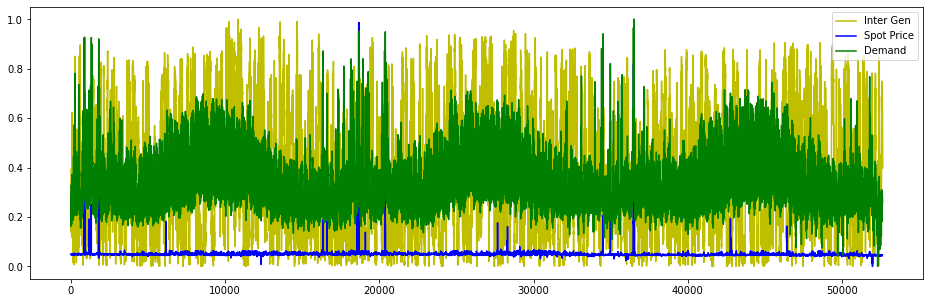

In [35]:
plt.figure(figsize=(16, 5))
plt.plot(train['inter_gen'], color='y', label='Inter Gen')
plt.plot(train['spot_price'], color='b', label='Spot Price')
plt.plot(train['demand'], color='g', label='Demand')
plt.legend()
plt.show()

Before applying the VAR model, all the time series variables in the data should be stationary. Stationarity is a statistical property in which time series show constant mean and variance over time.

One of the common methods to perform a stationarity check is the Augmented Dickey-Fuller test.

In the ADF test, there is a null hypothesis that the time series is considered non-stationary. So, if the p-value of the test is less than the significance level then it rejects the null hypothesis and considers that the time series is stationary.

In [23]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [24]:
adf_test(train['spot_price'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -23.36
p-value                    0.00
# lags used               57.00
# observations         52550.00
critical value (1%)       -3.43
critical value (5%)       -2.86
critical value (10%)      -2.57
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [25]:
adf_test(train['inter_gen'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -22.07
p-value                    0.00
# lags used               51.00
# observations         52556.00
critical value (1%)       -3.43
critical value (5%)       -2.86
critical value (10%)      -2.57
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [26]:
adf_test(train['demand'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -14.86
p-value                    0.00
# lags used               54.00
# observations         52553.00
critical value (1%)       -3.43
critical value (5%)       -2.86
critical value (10%)      -2.57
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [37]:
for i in [1,2,3,4,5,6,7,8,9,10]:
    model = VAR(train)
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()

Order = 1
AIC:  -23.235714103709146
BIC:  -23.23369066094228

Order = 2
AIC:  -24.42309539621874
BIC:  -24.41955431165284

Order = 3
AIC:  -24.436963624266276
BIC:  -24.4319048467064

Order = 4
AIC:  -24.43935146196411
BIC:  -24.43277494021259

Order = 5
AIC:  -24.45090746197459
BIC:  -24.442813144831018

Order = 6
AIC:  -24.453764650430394
BIC:  -24.444152486691628

Order = 7
AIC:  -24.456996695623555
BIC:  -24.44586663408372

Order = 8
AIC:  -24.459994578231637
BIC:  -24.44734656768212

Order = 9
AIC:  -24.46124909159971
BIC:  -24.44708308082917

Order = 10
AIC:  -24.462263117333976
BIC:  -24.44657905512833



In [41]:
result = model.fit(8)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 21, Sep, 2021
Time:                     10:50:53
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -24.4473
Nobs:                     52600.0    HQIC:                  -24.4560
Log likelihood:           419464.    FPE:                2.38319e-11
AIC:                     -24.4600    Det(Omega_mle):     2.37980e-11
--------------------------------------------------------------------
Results for equation spot_price
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.008368         0.000238           35.214           0.000
L1.spot_price         0.818738         0.004363          187.670           0.000
L1.inter_gen         -0.001499         0.001479        